<a href="https://colab.research.google.com/github/andreac941/tutorials/blob/main/A2b_DL_TC5033_AD2023_andrea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Team 1:**
* Alexis Hernández Martínez A01016308
* Rigoberto Vega Escudero A01793132
* Rodrigo Rodríguez Rodríguez A01183284
* Andrea Carolina Treviño Garza A01034993

# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

In [1]:
# Installation of requirements:
! pip install jupyterthemes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.0 MB/s eta 0:00:00


In [2]:
# Here we import all require libraries:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.optim as optim


# Only if you have jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

### Download Cifar10 dataset

In [3]:
# First we validate if there's some GPU available:
torch.cuda.is_available()

True

In [4]:
# Set the path for the CIFAR-10 dataset
DATA_PATH = './cifar10_data' # You can change this to your desired path
NUM_TRAIN = 50000            # We select 50,000 images for the training set.
NUM_VAL = 5000               # 5,000 images for the validation set.
NUM_TEST = 5000              # 5,000 images for the test set.
MINIBATCH_SIZE = 64          # And define a minibatch of 64 images.

# Definition of transforms, Compose() allows to have a list of transforms.
transform_cifar = T.Compose([
                T.ToTensor(), #First the data is transform to Tensor
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]) #Later Normalization is applied
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_cifar)  # Note: Validation set should also use train=True
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

# Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TEST)))

100%|██████████| 170498071/170498071 [00:02<00:00, 60729832.45it/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Here we can see what does cifar10_train (our training dataset) contains:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [6]:
# And validate the batchsize for the image loader of the training dataset.
train_loader.batch_size

64

In [7]:
# Here we can see the that the data in the train_loader are normalize --> close to zero (mean=0, std dev=1):
for i, (x, y) in enumerate(train_loader):
    print(x, y)

Se han truncado las últimas 5000 líneas del flujo de salida.
          [ 2.0131e+00,  1.6797e+00,  1.5844e+00,  ...,  1.4892e+00,
            1.5050e+00,  1.6638e+00],
          [ 1.9972e+00,  8.8585e-01,  4.0954e-01,  ...,  1.7139e-01,
            2.1902e-01,  1.2986e+00],
          ...,
          [ 1.9972e+00,  2.0314e-01, -7.6534e-01,  ...,  1.7139e-01,
            7.6129e-02,  1.2828e+00],
          [ 1.9813e+00,  1.4733e+00,  1.2351e+00,  ...,  1.3780e+00,
            1.5209e+00,  1.7749e+00],
          [ 2.0131e+00,  1.9972e+00,  2.0607e+00,  ...,  2.0449e+00,
            2.0290e+00,  1.9972e+00]],

         [[ 2.0510e+00,  2.0833e+00,  2.1317e+00,  ...,  2.1155e+00,
            2.0994e+00,  2.0994e+00],
          [ 2.0026e+00,  1.9058e+00,  1.9058e+00,  ...,  1.6960e+00,
            1.6798e+00,  1.7928e+00],
          [ 2.0510e+00,  1.1634e+00,  7.9222e-01,  ...,  5.0173e-01,
            4.5332e-01,  1.4377e+00],
          ...,
          [ 2.0671e+00,  2.4352e-01, -7.4090e-01,  

### Using  GPUs

In [8]:
# Validation of available GPUs:

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: dog


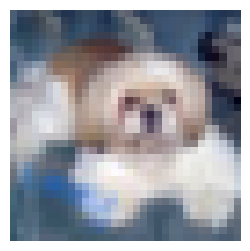

In [11]:
# Here we can display random images of the Test dataset:
classes = test_loader.dataset.classes # List of possible classes.
def plot_figure(image): # Function for displaying images
    plt.figure(figsize=(3,3))  # Smaller size selected to improve clarity of image.
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader)) # Random numbers generated, considering the maximum number in test_loader dataset.
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}') # Let's read the class of the image that will be displayed.
image = test_loader.dataset[rnd_sample_idx][0] # The image of the random number position in test dataset is saved.
image = (image - image.min()) / (image.max() - image.min() ) # Min-max normalization: data is scaled in range of 0 to 1.
plot_figure(image)


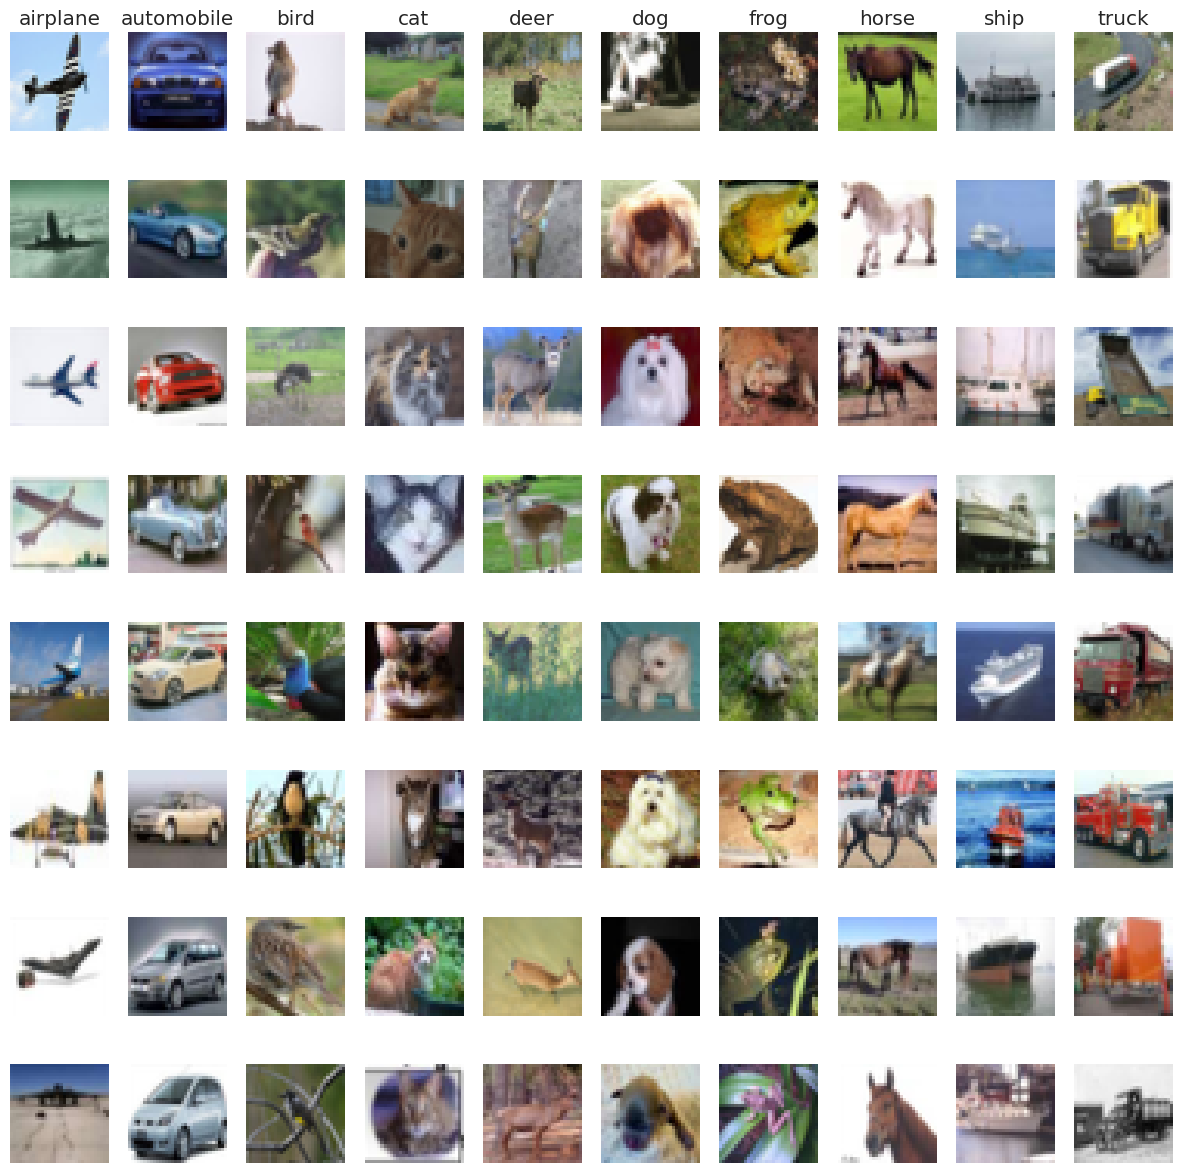

In [12]:
# Function for displaying a random images grid of the 10 classes x 8 samples of each class.
def plot_cifar10_grid():
    classes = test_loader.dataset.classes  # List of classes.
    total_samples = 8  # Number of samples.
    plt.figure(figsize=(15,15))  # Definition of size of the grid.
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets)) # Return the indices of the list that aren't zero in an array of test_loader dataset.
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False) # A random sample of 8 images is generated from a 1-D array.
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1  # Counter for the random number of the plot.
            plt.subplot(total_samples, len(classes), plt_idx) # In which subplot each image is displayed.
            plt.imshow(test_loader.dataset.data[idx]) # Displaying the random image from the sample in test_loader.
            plt.axis('off')

            if i == 0: plt.title(sample) # Displaying of the title of each class (column names of the grid)
    plt.show()

plot_cifar10_grid()

### Calcular accuracy


In [13]:
# Function for validating the accuracy of each model:
def accuracy(model, loader):
    """
    Computes the accuracy of the given model on the data provided by the loader.

    Args:
    - model (nn.Module): The neural network model.
    - loader (DataLoader): DataLoader for the dataset on which accuracy is to be calculated.

    Returns:
    - float: Accuracy of the model on the data provided by the loader.
    """

    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize counters
    num_correct = 0
    num_samples = 0

    # Use torch.no_grad to indicate to PyTorch that gradients should not be calculated
    with torch.no_grad():
        for x, y in loader:
            # Move data to the same device as the model (useful in case of GPUs)
            # x = x.to(device=model.device)
            # y = y.to(device=model.device)

            # Get the model predictions
            scores = model(x)
            _, predictions = scores.max(1)  # Get the index of max log-probability as the prediction

            # Update counters
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    # Calculate accuracy
    acc = float(num_correct) / num_samples
    return acc

# Display the function for verification
accuracy

<function __main__.accuracy(model, loader)>

### Loop de entrenamiento

In [14]:
# Modifying the train function to determine the device correctly:
def train(model, optimizer, epochs=100, loader=None, loss_fn=None):
    """
    Trains the given model using the specified optimizer and number of epochs.

    Args:
    - model (nn.Module): The neural network model.
    - optimizer (torch.optim.Optimizer): The optimizer for training.
    - epochs (int): Number of epochs for training. Default is 100.
    - loader (DataLoader): DataLoader for the training dataset.
    - loss_fn (nn.Module): Loss function. If None, uses CrossEntropyLoss.

    Returns:
    - list: List of losses for each epoch.
    """

    # Use CrossEntropyLoss by default if no loss function is provided
    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss()

    # Determine the device
    device = next(model.parameters()).device

    # List to store losses
    losses = []

    # Set the model to training mode
    model.train()

    for epoch in range(epochs):
        # Initialize epoch loss
        epoch_loss = 0.0

        for x, y in loader:
            # Move data to the determined device
            x = x.to(device=device)
            y = y.to(device=device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            scores = model(x)
            loss = loss_fn(scores, y)

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Accumulate the loss
            epoch_loss += loss.item()

        # Average epoch loss and add it to list losses
        avg_epoch_loss = epoch_loss / len(loader)
        losses.append(avg_epoch_loss)

        # Print loss for every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {avg_epoch_loss:.4f}")

    return losses

# Return the modified function for verification
train

<function __main__.train(model, optimizer, epochs=100, loader=None, loss_fn=None)>

### Linear model

In [24]:
# To do: Use PyTorch to create a linear model to have an initial baseline model
# LinearModel class is define:
class LinearModel(nn.Module):
    """
    A simple linear model for the CIFAR-10 dataset.
    """
    def __init__(self, input_dim=3072, num_classes=10):
        super(LinearModel, self).__init__()

        # Define the linear layer
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.size(0), -1)

        # Apply the linear transformation
        out = self.fc(x)
        return out

# Instantiate the model and display its architecture
linear_model = LinearModel()
linear_model

LinearModel(
  (fc): Linear(in_features=3072, out_features=10, bias=True)
)

In [16]:
# 1. Instantiate the linear model
model1 = LinearModel()

# 2. Define an optimizer
learning_rate = 1e-2
optimiser = optim.SGD(model1.parameters(), lr=learning_rate)
epochs=30

train(model1, optimiser,epochs, train_loader)

Epoch [0/20], Loss: 8.0464
Epoch [10/20], Loss: 7.0431


[8.046427918821955,
 7.846214027051121,
 7.566118676949035,
 7.460741911702754,
 7.368154042822016,
 7.378701923753295,
 7.346521598908603,
 7.2181182804010104,
 7.219962676162915,
 7.164085576601345,
 7.043107772117381,
 7.19926584529145,
 7.289715368119652,
 7.203937661617308,
 7.1628501784161225,
 7.12780472750554,
 7.197301842672441,
 7.227262643292127,
 7.16227032888271,
 7.104018522650384]

In [17]:
accuracy(model1,train_loader)

0.31738

In [15]:
# To do: Use PyTorch to create a linear model to have an initial baseline model
# LinearModel class is define:
class LinearModel1(nn.Module):
    """
    A simple linear model for the CIFAR-10 dataset.
    """
    def __init__(self, input_dim=32*32*3, num_classes=10): #3072 = 32*32*3
        super().__init__()

        # Define the linear layer
        self.fc1 = nn.Linear(input_dim, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        #self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.size(0), -1)

        # Apply the linear transformation to each layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1) #Softmax function applied to result of linear function in last layer.

# Instantiate the model and display its architecture
linear_model = LinearModel1()
linear_model

LinearModel1(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
# 1. Instantiate the linear model
model2 = LinearModel1()

# 2. Define an optimizer
learning_rate = 1e-2
#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=learning_rate)
epochs=30

train(model2, optimizer,epochs, train_loader)

Epoch [0/30], Loss: 1.9129
Epoch [10/30], Loss: 1.2018
Epoch [20/30], Loss: 0.9808


[1.9129448441593238,
 1.6458584743997324,
 1.5423375650135147,
 1.47240553563818,
 1.4171769085442623,
 1.370157784665637,
 1.330591683573735,
 1.2942684888839722,
 1.2600257948536397,
 1.2294324480968972,
 1.201790633256478,
 1.1764903664588928,
 1.1493176628104256,
 1.126333399120804,
 1.1051931881996067,
 1.0806347392404172,
 1.059583401207424,
 1.040347549387866,
 1.0187686081127743,
 1.0009670702697675,
 0.9807620595788102,
 0.966293908217374,
 0.9453533468648906,
 0.9286535049186033,
 0.9118944020832286,
 0.8947375694961499,
 0.8794766073031803,
 0.8603102944391158,
 0.8484115584579575,
 0.8329056161062797]

In [17]:
accuracy(model2,train_loader)

0.70782

### Sequential CNN

In [28]:
# To do: Use PyTorch to implement a CNN model, accuracy should be better than the linear model
class SimpleCNN(nn.Module):
    """
    A simple CNN model for the CIFAR-10 dataset.
    """
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) # Definition of 1st convolutional layer
        self.dropout1 = nn.Dropout(p=0.25) # Dropout of 25%
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # Definition of 2nd convolutional layer
        self.dropout1 = nn.Dropout(p=0.5) # Dropout of 50%
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Definition of 3rd convolutional layer

        # Define the pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)  # CIFAR-10 images are 32x32. After 3 pooling layers, they become 4x4
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Apply conv layers, followed the activation function & by pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor
        x = x.view(-1, 64 * 4 * 4)

        # Apply the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Instantiate the CNN model
modelCNN1 = SimpleCNN()
modelCNN1

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [29]:
# Define an optimizer, learning rate & number of epochs:
learning_rate = 1e-2
optimiser1 = optim.SGD(modelCNN1.parameters(), lr=learning_rate)
epochs=10

# Let's train our model with the parameters previously defined:
train(modelCNN1, optimiser1, epochs, train_loader)

Epoch [0/10], Loss: 2.1574


[2.157402445135824,
 1.7831975355782472,
 1.5327096113463496,
 1.4032608357536824,
 1.315648246451717,
 1.242286218096838,
 1.1736005199382373,
 1.1122784555872993,
 1.0547302007827613,
 0.9990749302727487]

In [30]:
# Validate the accuracy of our SimpleCNN model:
accuracy(modelCNN1,train_loader)

0.60726

In [26]:
# Another try for our CNN model, this time we add Batch Normalization to each conv layer & remove the dropout layers:
class SimpleCNN1(nn.Module):
    """
    A simple linear model for the CIFAR-10 dataset. Batch Normalization is added to the output of each conv layer & the dropout layers are removed
    """
    def __init__(self, num_classes=10):
        super(SimpleCNN1, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) # Definition of 1st convolutional layer
        self.bn1 = nn.BatchNorm2d(16) # Batch Normalization for 1st layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # Definition of 2nd convolutional layer
        self.bn2 = nn.BatchNorm2d(32) # Batch Normalization for 2nd layer
        #self.dropout1 = nn.Dropout(p=0.5) # Dropout of 50%
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Definition of 3rd convolutional layer
        self.bn3 = nn.BatchNorm2d(64) # Batch Normalization for 3rd layer

        # Define the pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)  # CIFAR-10 images are 32x32. After 3 pooling layers, they become 4x4
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Apply conv layers followed by batch normalization, the activation function & by pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the tensor
        x = x.view(-1, 64 * 4 * 4)

        # Apply the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Instantiate the CNN model
modelCNN2 = SimpleCNN1()
modelCNN2

SimpleCNN1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [27]:
# Define an optimizer, the learning rate & number of epochs:
learning_rate = 1e-2
optimiser2 = optim.SGD(modelCNN2.parameters(), lr=learning_rate)
epochs=10

# Let's train our model with the parameters previously defined:
train(modelCNN2, optimiser2, epochs,train_loader)

Epoch [0/10], Loss: 1.5199


[1.519910371364535,
 1.1532756001748088,
 1.0000617385215467,
 0.9107128520832037,
 0.8410112372673381,
 0.7869320630341234,
 0.7403849452124227,
 0.7014390377284926,
 0.6638020770933927,
 0.6287316559525706]

In [28]:
# Validate the accuracy of our modelCNN2:
accuracy(modelCNN2,train_loader)

0.70994

In [18]:
# Another try for our CNN model, this time we leave the Batch Normalization to each conv layer & add again the dropout layers:
class SimpleCNN2(nn.Module):
    """
    A simple linear model for the CIFAR-10 dataset. Batch Normalization is added to the output of each conv layer & the dropout layers are added once again.
    """
    def __init__(self, num_classes=10):
        super(SimpleCNN2, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) # Definition of 1st convolutional layer
        self.bn1 = nn.BatchNorm2d(16) # Batch Normalization for 1st layer
        self.dropout1 = nn.Dropout(p=0.25) # Dropout of 25%
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # Definition of 2nd convolutional layer
        self.bn2 = nn.BatchNorm2d(32) # Batch Normalization for 2nd layer
        self.dropout1 = nn.Dropout(p=0.5) # Dropout of 50%
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Definition of 3rd convolutional layer
        self.bn3 = nn.BatchNorm2d(64) # Batch Normalization for 3rd layer

        # Define the pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)  # CIFAR-10 images are 32x32. After 3 pooling layers, they become 4x4
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Apply conv layers, followed by batch normalization, activation function & by pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the tensor
        x = x.view(-1, 64 * 4 * 4)

        # Apply the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Instantiate the CNN model
modelCNN3 = SimpleCNN2()
modelCNN3

SimpleCNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [19]:
# Define an optimizer, the learning rate & number of epochs:
learning_rate = 1e-2
optimiser3 = optim.SGD(modelCNN3.parameters(), lr=learning_rate)
epochs=10

# Let's train our model with the parameters previously defined:
train(modelCNN3, optimiser3, epochs,train_loader)

Epoch [0/10], Loss: 1.5029


[1.5029157941298716,
 1.1229055879823386,
 0.9781639640745909,
 0.8923630467461198,
 0.828163341297518,
 0.7757142660258066,
 0.7310446240865361,
 0.6934828566544501,
 0.6608762115697422,
 0.6282953176733173]

In [20]:
# Validate the accuracy of our modelCNN3:
accuracy(modelCNN3,train_loader)

0.78026

In [21]:
# Define an optimizer, the learning rate & number of epochs:
learning_rate = 1e-2
optimiser4 = optim.SGD(modelCNN3.parameters(), lr=learning_rate)
epochs1=20 # Here we duplicated de number of epochs

# Let's train our model with the parameters previously defined:
train(modelCNN3, optimiser4, epochs1, train_loader)

Epoch [0/20], Loss: 0.5962
Epoch [10/20], Loss: 0.3594


[0.596179127273962,
 0.5669901641585943,
 0.5424633164844854,
 0.515485131736759,
 0.490639848744168,
 0.46665799644444605,
 0.4433547652819577,
 0.4225796047035995,
 0.4029623719165697,
 0.3804983919119591,
 0.35944930060059216,
 0.34349706839493777,
 0.32601281646115093,
 0.3103041661250622,
 0.28841661071152336,
 0.270055552777808,
 0.2555499834858853,
 0.24100501660991203,
 0.22185336685527468,
 0.20930317797891015]

In [22]:
# Validate the accuracy of our modelCNN3 (with epochs = 20):
accuracy(modelCNN3,train_loader)

0.85674

In [25]:
# Validate the accuracy of our model in the test dataset.
accuracy(modelCNN3,test_loader)

0.8646

## **Bibliografía:**

* Pepe Cantoral, Ph.D. (2022, January 15). Red Neuronal Convolucional en PyTorch / Tutorial de PyTorch para CNN - Parte 1 [Video]. YouTube. https://www.youtube.com/watch?v=yUB9JQQVtoU
* Pepe Cantoral, Ph.D. (2022b, January 18). Red Neuronal Convolucional en PyTorch con Batch Normalization/Tutorial de PyTorch para CNNs -Parte 2 [Video]. YouTube. https://www.youtube.com/watch?v=NLrQZwnWjvI
* Training a Classifier — PyTorch Tutorials 2.1.0+cu121 documentation. (n.d.). https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* Zivkovic, S. (2021, November 15). #010 PyTorch - Artificial Neural Network with Perceptron on CIFAR10 using PyTorch. Master Data Science. https://datahacker.rs/009-pytorch-building-an-artificial-neural-network-with-perceprton-on-cifar10-using-pytorch/